<a href="https://colab.research.google.com/github/ckim0130/DLself-driving-car-/blob/main/Car_YOLOv3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# clone darknet repo
!git clone https://github.com/AlexeyAB/darknet/

Cloning into 'darknet'...
remote: Enumerating objects: 15043, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 15043 (delta 14), reused 20 (delta 8), pack-reused 15002
Receiving objects: 100% (15043/15043), 13.47 MiB | 16.34 MiB/s, done.
Resolving deltas: 100% (10213/10213), done.


In [ ]:
# change makefile to have GPU and OPENCV enabled
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
# if you wanna make libdarknet.so
#!sed -i 's/LIBSO=0/LIBSO=1/' Makefile

/content/darknet


In [ ]:
# make darknet (build)
!make

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# this creates a symbolic link so that now the path /content/gdrive/My\ Drive/ is equal to /mydrive
!ln -s /content/drive/MyDrive/ /mydrive
!ls /mydrive


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [ ]:
cd /content

/content


In [ ]:
model_path = '/content/drive/MyDrive/self-driving-repository/lane_detection/enet_model'

In [ ]:
enet = tf.keras.models.load_model(model_path, compile = False)

In [ ]:
filename = '/content/darknet/data/training_data/4735.png'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


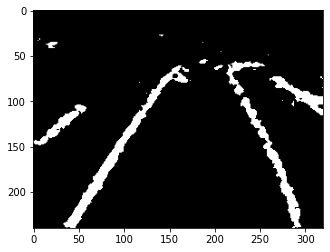

In [ ]:
img = tf.io.read_file(train_images_path + '4735.png')
img = tf.image.decode_png(img, channels=3)
img = tf.image.convert_image_dtype(img, tf.float32)
img = tf.image.resize(img, [240, 320])
enc_im, dec_im = enet(tf.expand_dims(img, axis=0))
img = 1000*dec_im[0,:,:,0].numpy()
img[img < 100] = 0
img[img > 150] = 150
lane_image = np.stack([img, img, img], axis = 2)
plt.imshow(lane_image)

In [ ]:
!cp /mydrive/self-driving-repository/lane_detection/enet_model_250.zip ../
!unzip ../enet_model_250.zip -d /mydrive/self-driving-repository/lane_detection/

Archive:  ../enet_model_250.zip
replace /mydrive/self-driving-repository/lane_detection/enet_model/saved_model.pb? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /mydrive/self-driving-repository/lane_detection/enet_model/saved_model.pb  
replace /mydrive/self-driving-repository/lane_detection/enet_model/variables/variables.data-00000-of-00001? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /mydrive/self-driving-repository/lane_detection/enet_model/variables/variables.data-00000-of-00001  
replace /mydrive/self-driving-repository/lane_detection/enet_model/variables/variables.index? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /mydrive/self-driving-repository/lane_detection/enet_model/variables/variables.index  


In [ ]:
# upload the obj.names and obj.data files to cloud VM from Google Drive
!cp /mydrive/yolov3/obj.names ./data
!cp /mydrive/yolov3/obj.data  ./data

In [ ]:
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()

In [ ]:
def get_image(preds):
  color_dct = {0 : [100,0,0], 1 : [0,100,0], 2 : [0,0,100], 3: [255,0,0]}
  def get_Slices(x1,x2,w,h):
    i_index = np.array([x1 + i -1 for i in range(w)], dtype = np.int32)
    j_index = np.array([x2 + i -1 for i in range(h)], dtype = np.int32)
    i_index = i_index[i_index < 320]
    i_index = i_index[0 <= i_index]
    j_index = j_index[j_index < 240]
    j_index = j_index[0 <= j_index]
    paint_index = np.meshgrid(j_index, i_index)
    return paint_index



  image = np.zeros([240, 320, 3])
  for pred in preds:
    color = color_dct[pred[0]]
    paint_mesh = get_Slices(pred[1],pred[2],pred[3],pred[4])
    image[paint_mesh] = color
  return image


In [ ]:
train_images = []
for index, file in enumerate(train_image_paths):
    image = cv2.imread(file)
    if image is not None:
        train_images.append(cv2.imread(file))